# Example: Build a Hidden Markov Model of Daily Stock Excess Growth Rate
In this example, we analyze an in-sample hidden Markov model (HMM) applied to the growth rate of the SPY ETF. We will set up the HMM, estimate its parameters using historical SPY growth rate data, and evaluate its performance in capturing the stylized facts governing financial time series.

> __Learning Objectives:__
> 
> By the end of this example, you will be able to:
> * __Construct hidden Markov models from excess return data:__ Build discrete state spaces by partitioning historical excess returns into categories using cumulative distribution functions, estimate transition probability matrices from observed state sequences, and generate stationary distributions from estimated transition matrices.
> * __Simulate standard and jump-augmented HMM return trajectories:__ Generate synthetic return sequences using standard transition matrices and stationary distributions, implement jump models with Poisson-distributed tail state durations to capture extreme events, and decode state sequences into excess return values using fitted Normal distributions.
> * __Validate model performance using statistical tests and autocorrelation analysis:__ Apply Kolmogorov-Smirnov tests to compare observed and simulated return distributions, compute autocorrelation functions of absolute returns to assess volatility clustering, and compare standard versus jump-augmented model performance in reproducing observed data properties.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

### Data
We gathered a daily open-high-low-close dataset for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2014` until `12-31-2024`, along with data for a few exchange-traded funds and volatility products during that time. 

Let's load the `original_dataset::DataFrame` by calling [the `MyTrainingMarketDataSet()` function](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/data/#VLDataScienceMachineLearningPackage.MyTrainingMarketDataSet) and remove firms that do not have the maximum number of trading days. The cleaned dataset $\mathcal{D}$ will be stored in the `dataset` variable.

In [2]:
original_dataset = MyTrainingMarketDataSet() |> x-> x["dataset"];

Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.

First, let's compute the number of records for a firm that we know has a maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days::Int64` variable:

In [3]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [4]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset;

Finally, let's get a list of the firms in our cleaned dataset (and sort them alphabetically). We store the sorted firm ticker symbols in the `list_of_tickers::Array{String,1}` variable.

In [5]:
list_of_tickers = keys(dataset) |> collect |> sort; # list of firm "ticker" symbols in alphabetical order

### Constants and Parameters
Let's define some constants and parameters that we will use in this example. See the comment lines next to each variable for a description of its purpose, units, permissible values, etc.

In [6]:
Δt = (1.0 / 252.0); # time step (in years) between trading days (assumes 252 trading days per year)
risk_free_rate = 0.043; # annualized risk-free interest rate (4.3% per year)
myticker = "SPY"; # ticker symbol for the SPY ETF

# palette -
# my_color_palette = Dict{Int64,RGB}();
# my_color_palette[0] = colorant"#e5e5e5";
# my_color_palette[1] = colorant"#ff7d00";
# my_color_palette[2] = colorant"#14213d";
# my_color_palette[3] = colorant"#ffecd1";
# my_color_palette[4] = colorant"rgb(49,52,58)";
# my_color_palette[5] = colorant"#c0d6df";
# my_color_palette[6] = colorant"#000000";

"SPY"

### Growth Rate Calculation
Finally, let's compute the daily growth rate time series for all firms in our cleaned dataset. We will store the growth rate time series for each firm in the `all_firms_excess_return_matrix::Array{Float64,2}` variable.

In [7]:
all_firms_excess_return_matrix = log_growth_matrix(dataset, list_of_tickers, 
    Δt = Δt, risk_free_rate = risk_free_rate);

The growth rate that we will model will be stored in the `Rᵢ::Array{Float64,1}` variable for firm `myticker::String`. 

In [8]:
Rᵢ = findfirst(x->x==myticker, list_of_tickers) |> i-> all_firms_excess_return_matrix[:,i];

___

## Task 1: Construct the states $\mathcal{S}$, the emission matrix $\mathbf{E}$ and transition matrix $\hat{\mathbf{T}}$
In this task, we will construct the states $\mathcal{S}$, the emission matrix $\mathbf{E}$, and the transition matrix $\hat{\mathbf{P}}$ for our hidden Markov model (HMM) of daily stock excess growth rates. First, consider the states $\mathcal{S}$. 

> __Idea__
> 
> __States:__ The states $\mathcal{S}$ represent the underlying (hidden) market conditions influencing the observed excess returns. Define a finite number of discrete states to capture different market regimes, where we label (and number) the excess return values, ranging from `super bad = 1,` $\dots$,` unchanged,` $\dots$,` super good = N,` where if $R\ll{0}$, then we are  in the `super bad = 1,` state or $R\gg{0}$ we are in the `super good = N` state (or we are someplace in between). 
> 
> __Distribution:__ Use the [cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function) computed from the observed return series $R_{i,1}, \dots, R_{i,n}$ to partition the actual (historical) excess returns into one of a fixed number of categories. Once we have the categories, compute the probability that category $i$ on the day $k$ is followed by category $j$ on the day $k+1$. These values are entries in the state transition matrix $\hat{\mathbf{P}}$.

To start, specify a value for the  `number_of_states::Int` variable, where the `number_of_states::Int` controls how many categories we are using when splitting up the excess return time series. We then set the `states` vector, which holds the states (numbered from `1`$\rightarrow$`number_of_states`). 

In [9]:
number_of_states = 100; # TODO: specify a value here
states = range(1,stop=number_of_states) |> collect;

The `states` are hidden from the observer. Next, we set up the emissions matrix $\mathbf{E}$. For this example, because the states are __fully observable__, i.e., we can see the states directly,  the emission matrix $\mathbf{E}$ is the identity matrix $\mathbf{I}$:

In [10]:
E = diagm(ones(number_of_states)); # emission matrix, identity matrix of size `number_of_states` x `number_of_states`

### Estimate the transition matrix $\hat{\mathbf{T}}$ from market data
To estimate the transition matrix $\hat{\mathbf{T}}$, we'll estimate the transition probabilities from the excess return data calculated in the `Prerequisites` section and saved in the `Rᵢ` variable. 

In [11]:
in_sample_dataset = Rᵢ[1:(maximum_number_trading_days-1)] # set of excess return

2766-element Vector{Float64}:
 -0.6275399670984476
  0.8396262386945091
  0.16299199696256234
 -0.01113369193943612
  0.25733420862761536
 -1.378988774125505
  0.32151271641711465
  2.0000590819913135
 -0.32304976380825395
 -0.436880737916184
  ⋮
 -3.8191858909074563
 -3.0876707822786664
  0.233632780780899
  1.6080264971962088
  2.6888092382740747
  0.7444999191864144
 -2.7618744641560036
 -2.505501843730946
 -0.9633409493684527

Next, we need to model the return data distribution to compute the [cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function). The excess return distribution is a random variable that follows some [probability distribution function](https://en.wikipedia.org/wiki/Probability_distribution). We don't know what that distribution function is, but for now, we assume the excess returns follow a [Laplace distribution](https://en.wikipedia.org/wiki/Laplace_distribution)

We use the [fit_mle function](https://juliastats.org/Distributions.jl/stable/fit/#Distributions.fit_mle-Tuple{Any,%20Any}) exported by the [Distributions.jl package](https://github.com/JuliaStats/Distributions.jl) to fit a [Laplace distribution](https://en.wikipedia.org/wiki/Laplace_distribution) to our our data. We fit the distribution to the full dataset `Rₘ` and save the distribution in the `d` variable.

In [12]:
d = fit_mle(Laplace, Rᵢ); # use the *full* data set to establish the cutoff's

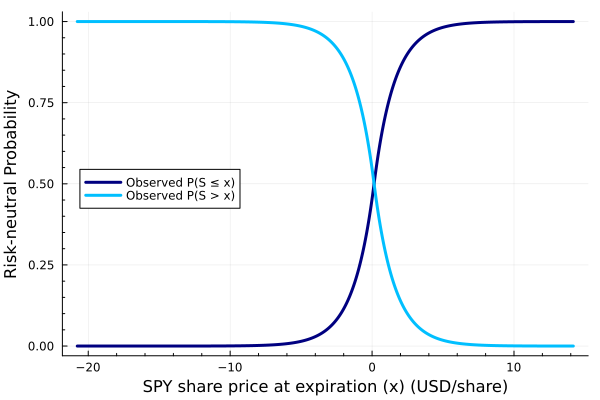

In [13]:
let

    # regions of return -
    number_of_samples = 1000;
    minimum_obs_growth = minimum(in_sample_dataset);
    maximum_obs_growth = maximum(in_sample_dataset);
    RA = range(minimum_obs_growth,stop = maximum_obs_growth, length = number_of_samples) |> collect;

    X = Array{Float64,2}(undef, number_of_samples,2);
    for i ∈ eachindex(RA)
    
        X[i,1] = RA[i];
        X[i,2] = cdf(d, RA[i]);
    end

    plot(X[:,1], X[:,2], lw=3, c=:navy, label="Observed P(S ≤ x)", xminorticks=5, yminorticks=5)
    plot!(X[:,1], 1 .- X[:,2], lw=3, c=:deepskyblue1, label="Observed P(S > x)", legend=:left)

    xlabel!("$(myticker) share price at expiration (x) (USD/share)", fontsize=18);
    ylabel!("Risk-neutral Probability", fontsize=18);
end

Next, we generate the percentile cutoffs that we use to establish the bounds that correspond to each category of return, i.e., `super bad` or `super good`, etc.

In [14]:
percentage_cutoff = range(0.0,stop=1.0,length=(number_of_states+1)) |> collect;

Now that we have the cutoffs, compute the lower and upper bound for each potential category. To do this, we'll use the [quantile function](https://juliastats.org/Distributions.jl/stable/univariate/#Statistics.quantile-Tuple{UnivariateDistribution,%20Real}) exported by the [Distributions.jl package](https://github.com/JuliaStats/Distributions.jl). For a given `0 ≤ q ≤ 1`, `quantile(d, q)` is the smallest value `x` 
for which `cdf(d, x) ≥ q`.

In [15]:
bounds = let

    # initialize -
    bounds = Array{Float64,2}(undef, number_of_states, 3)
    
    # compute bounds -
    for s ∈ states
        bounds[s,1] = quantile(d,percentage_cutoff[s])
        bounds[s,2] = quantile(d,percentage_cutoff[s+1])
        bounds[s,3] = s
    end
    bounds; # return bounds
end

100×3 Matrix{Float64}:
 -Inf       -5.55445    1.0
  -5.55445  -4.54514    2.0
  -4.54514  -3.95474    3.0
  -3.95474  -3.53584    4.0
  -3.53584  -3.21091    5.0
  -3.21091  -2.94543    6.0
  -2.94543  -2.72097    7.0
  -2.72097  -2.52653    8.0
  -2.52653  -2.35503    9.0
  -2.35503  -2.20161   10.0
   ⋮                  
   2.63888   2.81038   92.0
   2.81038   3.00482   93.0
   3.00482   3.22928   94.0
   3.22928   3.49476   95.0
   3.49476   3.81969   96.0
   3.81969   4.23859   97.0
   4.23859   4.82899   98.0
   4.82899   5.8383    99.0
   5.8383   Inf       100.0

Now that we have the category bounds, let's take the excess return data and determine which state an excess return observation corresponds to. For each sample in the `in_sample_dataset`:

Classify the sample value into one of the possible categories. Let `state = 1` equal the worst return, and `state = number_of_states` equal the best return. Save these results in the `encoded_in_sample` array:

In [16]:
encoded_in_sample = let

    # initialize -
    encoded_in_sample = Array{Int64,1}();

    for i ∈ eachindex(in_sample_dataset)
        value = in_sample_dataset[i];

        class_index = 1;
        for s ∈ states
            if (bounds[s,1] ≤ value && value < bounds[s,2])
                class_index = s;
                break;
            end
        end
        push!(encoded_in_sample, class_index);
    end
    encoded_in_sample; # return
end

2766-element Vector{Int64}:
 30
 70
 51
 46
 54
 18
 56
 87
 37
 34
  ⋮
  4
  6
 54
 82
 92
 67
  7
  9
 24

In the matrix $\mathbf{P}$ compute the `counts` for transition from state `i` to state `j`:

In [17]:
P = let

    # initialize -
    P = zeros(number_of_states, number_of_states)
    number_insample = length(encoded_in_sample);
    
    # main loop -
    for i ∈ 2:number_insample
        start_index = encoded_in_sample[i-1];
        stop_index = encoded_in_sample[i];
        P[start_index,stop_index] += 1;
    end
    P; # return
end

100×100 Matrix{Float64}:
 8.0  3.0  2.0  1.0  2.0  2.0  0.0  0.0  …  1.0  1.0  2.0  0.0  0.0  0.0  2.0
 3.0  2.0  1.0  0.0  0.0  1.0  0.0  0.0     1.0  0.0  1.0  0.0  1.0  0.0  1.0
 1.0  0.0  0.0  0.0  2.0  0.0  1.0  1.0     0.0  1.0  0.0  0.0  0.0  1.0  0.0
 4.0  1.0  2.0  0.0  0.0  2.0  0.0  1.0     0.0  1.0  0.0  1.0  1.0  0.0  1.0
 2.0  0.0  1.0  0.0  0.0  0.0  0.0  3.0     0.0  0.0  0.0  0.0  0.0  0.0  2.0
 1.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0  …  0.0  1.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  2.0  0.0  1.0  2.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 2.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 1.0  2.0  0.0  0.0  1.0  1.0  0.0  1.0     1.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0     0.0  0.0  1.0  0.0  0.0  1.0  0.0
 ⋮                        ⋮              ⋱            ⋮                   
 0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0     1.0  0.0  0.0  0.0  0.0  1.0  1.0
 2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

From the `counts` matrix $\mathbf{P}$, compute the transition probability matrix $\hat{\mathbf{P}}$::`Array{Float64,2}` by normalizing each row of the `counts` matrix by the sum of the row:

In [18]:
P̂ = let

    # initialize -
    P̂ = zeros(number_of_states, number_of_states)
    for row ∈ states
        Z = sum(P[row,:]);
        for col ∈ states
            P̂[row,col] = (1/Z)*P[row,col]
        end
    end
    P̂; # return
end

100×100 Matrix{Float64}:
 0.170213   0.0638298  0.0425532  …  0.0        0.0        0.0425532
 0.107143   0.0714286  0.0357143     0.0357143  0.0        0.0357143
 0.0434783  0.0        0.0           0.0        0.0434783  0.0
 0.133333   0.0333333  0.0666667     0.0333333  0.0        0.0333333
 0.0689655  0.0        0.0344828     0.0        0.0        0.0689655
 0.0434783  0.0434783  0.0434783  …  0.0        0.0        0.0
 0.0        0.0        0.0           0.0        0.0        0.0
 0.0606061  0.030303   0.030303      0.0        0.0        0.0
 0.037037   0.0740741  0.0           0.0        0.0        0.0
 0.030303   0.030303   0.030303      0.0        0.030303   0.0
 ⋮                                ⋱                        
 0.0        0.0344828  0.0           0.0        0.0344828  0.0344828
 0.0625     0.0        0.0           0.03125    0.0        0.03125
 0.0434783  0.0        0.0434783     0.0        0.0        0.0
 0.04       0.04       0.0           0.04       0.0        0.0

___

## Task 2: Simulate the Hidden Markov Model (HMM)
To do the simulation, we first build a [`MyHiddenMarkovModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/markov/#VLQuantitativeFinancePackage.MyHiddenMarkovModel), which holds the data for our Markov model. We use a [`build(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/markov/#VLQuantitativeFinancePackage.build-Tuple{Type{MyHiddenMarkovModel},%20NamedTuple}), which takes information about the `states,` the estimated transition matrix $\hat{\mathbf{P}}$, and the emission matrix $\mathbf{E}$ and returns a [`MyHiddenMarkovModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/markov/#VLQuantitativeFinancePackage.MyHiddenMarkovModel), which we save in the `model` variable.

In [19]:
model = build(MyHiddenMarkovModel, (
    states = states, # states
    T = P̂, # transition matrix (estimate)
    E = E # emission matrix
));

### Generate the stationary distribution from the estimated $\hat{\mathbf{P}}$ matrix
Generate the stationary distribution for the estimated transition matrix $\hat{\mathbf{P}}$ and use it to construct a [Categorical distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Categorical) representing the stationary distribution. Save the [Categorical distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Categorical) in the `π̄` variable:

In [20]:
power_value = 50;
π̄ = (P̂^power_value) |> tmp -> Categorical(tmp[1,:]); # TODO: compute the stationary distribution (approx value is ok)

### Generate hypothetical return sequences
Generate `number_of_paths::Int64` example sequences, each containing `number_of_steps::Int64` days. These variables determine the length and number of our hypothetical return sequences. Assume each path starts from a draw from the stationary distribution `π̄`.
* Save the simulated return sequences in the `archive::Array{Int64,2}(undef, number_of_steps, number_of_paths)` array, where the `row` index corresponds to a path, and the `col` index corresponds to a day.
* We have implemented some shortcut logic to speed up the implementation. To evaluate the Markov model for `number_of_steps`, issue the command `model(start_state, number_of_steps)`. This will compute a chain with `number_of_steps` starting as `start_state` and return the simulated sequence as an `array`. 

In [21]:
encoded_archive, number_of_paths = let

    number_of_paths = 100;
    number_of_steps = maximum_number_trading_days;
    encoded_archive = Array{Int64,2}(undef, number_of_steps, number_of_paths);
    
    for i ∈ 1:number_of_paths
        start_state = rand(π̄);
        tmp = model(start_state, number_of_steps) # wow! That's fancy. Isn't model a type??
        for j ∈ 1:number_of_steps
            encoded_archive[j,i] = tmp[j,1]
        end
    end
    (encoded_archive, number_of_paths)
end

([19 59 … 78 1; 42 47 … 34 22; … ; 3 53 … 87 92; 90 33 … 6 92], 100)

In [22]:
actual_sample_bounds = copy(bounds);
actual_sample_bounds[1,1] = minimum(in_sample_dataset);
actual_sample_bounds[end,2] = maximum(in_sample_dataset)
actual_sample_bounds

100×3 Matrix{Float64}:
 -20.7731   -5.55445    1.0
  -5.55445  -4.54514    2.0
  -4.54514  -3.95474    3.0
  -3.95474  -3.53584    4.0
  -3.53584  -3.21091    5.0
  -3.21091  -2.94543    6.0
  -2.94543  -2.72097    7.0
  -2.72097  -2.52653    8.0
  -2.52653  -2.35503    9.0
  -2.35503  -2.20161   10.0
   ⋮                  
   2.63888   2.81038   92.0
   2.81038   3.00482   93.0
   3.00482   3.22928   94.0
   3.22928   3.49476   95.0
   3.49476   3.81969   96.0
   3.81969   4.23859   97.0
   4.23859   4.82899   98.0
   4.82899   5.8383    99.0
   5.8383   14.1795   100.0

### Decode operation
To turn the state $s\in\mathcal{S}$ back into an excess return value, we need to __decode__ the state. To do this, let's construct a [Normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) describing the observed return values associated with each state in the `encoded_in_sample` dataset.

We collect the observed excess return samples associated with a particular state $s$, store them in a `tmp` array, and use [Maximum Likelihood Estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) to estimate a [Normal distribution exported from the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal)

In [23]:
decode_distribution_model = Dict{Int,Normal}()
for s ∈ states

    # what indexes correspond to state s
    index_collection_state_s = findall(x-> x == s, encoded_in_sample);
    tmp = Array{Float64,1}();
    for i ∈ index_collection_state_s
        decoded_value = Rᵢ[i];
        push!(tmp, decoded_value);
    end
    decode_distribution_model[s] = fit_mle(Normal,tmp);
end
decode_distribution_model;

Then, generate a random value for the excess return by sampling the appropriate [Normal distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal). We develop `number_of_paths` trajectories, each containing `number_of_steps` values. We store these values in the `decoded_archive` variable:

In [24]:
in_sample_decoded_archive = let

    # initialize -
    number_of_steps = maximum_number_trading_days;
    in_sample_decoded_archive = Array{Float64,2}(undef, number_of_steps, number_of_paths);
    
    for i ∈ 1:number_of_paths
        for j ∈ 1:number_of_steps
            s = encoded_archive[j,i];
            in_sample_decoded_archive[j,i] =  decode_distribution_model[s] |> d -> rand(d)
        end
    end
    in_sample_decoded_archive # actual excess growth value
end

2767×100 Matrix{Float64}:
 -1.29301     0.393427   -0.905349    …   2.0483     1.30247     -0.665223
 -0.117097    0.024685   -2.65297        -0.286052  -0.409811    -1.08926
 -0.523602    0.55302    -1.20978         2.05092   -0.136941    -0.54154
 -0.492986   -0.484569    1.01721        -0.167402  -1.91007     -0.830169
  0.238834   -0.79855     1.77134         0.518072  -0.0319064    4.4778
  0.323604   -1.48212    -0.0489219   …   0.196103   5.49995     -1.11622
  1.23488     2.01139     0.00200098     -3.68031    0.509828    -0.755533
 -3.89648     4.37014    -0.197182       -3.21977   -3.00607      1.4475
 -5.88504     0.860331   -0.518654        2.39652    2.39082      1.30698
 -0.14711    -0.260725    4.00709         1.20651   -3.225        0.487067
  ⋮                                   ⋱                         
 -0.0398367   1.3246      1.76001        -1.53846    1.04726     -3.64431
  0.122644    2.87758     0.845239        2.3932    -2.23365     -7.00807
 -2.80627     0.013

### Visualize an example in-sample return trajectory
`Unhide` the code block to see how we plotted the observed (red) and simulated (blue) excess growth rate values for a randomly selected sample model generated sample path.

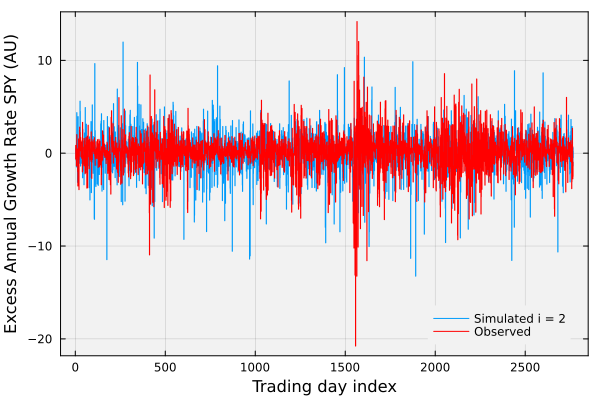

In [25]:
let
    index_to_plot = rand(1:number_of_paths);
    plot(in_sample_decoded_archive[:,index_to_plot], linetype=:steppost, label="Simulated i = $(index_to_plot)", 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    plot!(in_sample_dataset, linetype=:steppost, c=:red, label="Observed")
    xlabel!("Trading day index", fontsize=18)
    ylabel!("Excess Annual Growth Rate $(myticker) (AU)", fontsize=18)
end

`Unhide` the code block below to see how we plotted the observed and simulated excess annual growth rate distribution for the in-sample data.

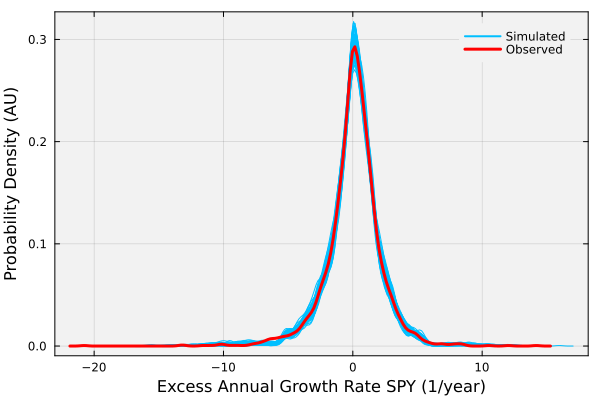

In [26]:
let
    q = plot(); 
    density!(in_sample_decoded_archive[:,1], lw=2, c=:deepskyblue1, label="Simulated", 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    for i ∈ 2:number_of_paths
        density!(in_sample_decoded_archive[:,i], lw=1, c=:deepskyblue1, label="")
    end
    density!(in_sample_dataset, c=:red, lw=3, label="Observed")
    xlabel!("Excess Annual Growth Rate $(myticker) (1/year)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
    current()
end

### Check: Are the predicted and observed in-sample distributions the same? 
If our Markov model is correct, then the observed excess growth rate distribution and the excess growth distribution calculated by our model should look like they are drawn from the same distribution. To check this hypothesis, use [the ApproximateTwoSampleKSTest exported by the HypothesisTests.jl package](https://github.com/JuliaStats/HypothesisTests.jl) with the hypotheses:

> __Test:__ The `H0:null hypothesis` is that `x` and `y` are drawn from the same distribution against the `H1:alternative hypothesis` that `x` and `y` come from different distributions.

Let's run [the ApproximateTwoSampleKSTest function](https://github.com/JuliaStats/HypothesisTests.jl) on a single (randomly selected) example trajectory to see what happens (most of the time, we fail to reject `H0`, i.e., the test suggests `x` and `y` are from the same distribution): 

In [27]:
ApproximateTwoSampleKSTest(in_sample_dataset,in_sample_decoded_archive[:,rand(1:number_of_paths)])

Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.0176314

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.7831

Details:
    number of observations:   [2766,2767]
    KS-statistic:              0.655746739785643


However, we have `number_of_paths` example trajectories (not just one), so let's do the same test on each sample and compute an overall expected score. Specify a `pvalue_cutoff` value to check against. If the test returns `pvalue > pvalue_cutoff,` then we fail to reject `H0:null hypothesis`, i.e., `x` and `y` appear to be drawn from the same distribution.

In [28]:
let
    pvalue_cutoff = 0.05; # cutoff 
    pass_counter = 0;
    for i ∈ 1:number_of_paths
        test_value = ApproximateTwoSampleKSTest(in_sample_dataset,in_sample_decoded_archive[:,i]) |> pvalue
        if (test_value > pvalue_cutoff)
            pass_counter += 1 # we pass (fail to reject) x and y are from the same distribution
        end
    end
    println("Pass percentage: $((pass_counter/number_of_paths)*100)%")
end

Pass percentage: 100.0%


___

## Task 3: What does our Jump model do?
In this task, we explore a modified Markov model that includes jumps. Suppose every so often, instead of transitioning to the next state by sampling the transition matrix, we jump to a __tail state__ of the cumulative distribution. We then stay in one of the tail states for a random number of steps, governed by a [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution).

To explore this idea, we built [a `MyHiddenMarkovModelWithJumps` instance](src/Types.jl), which holds the same data as the non-jump model. However, we now have two new parameters: the `ϵ::Float64` parameter controls the frequency with which we observe jumps, and the `λ::Int64` parameter is the mean number of events that occur in a given time frame.

We save this model in the `jump_model::MyHiddenMarkovModelWithJumps` variable.

In [29]:
jump_model = let
    
    model = build(MyHiddenMarkovModelWithJumps, (
        states = states,
        T = P̂, 
        E = E,
        ϵ = 0.0001, # fraction of steps that we have a jump event
        λ = 63, # mean number of jump events
    ));

    model;
end;

__Sample__: Next, we sample the `jump_model::MyHiddenMarkovModelWithJumps` model. Sampling the model results in the `encoded_archive_with_jumps::Array{Float64,2}` array, which holds sample paths (alternative futures) on the columns and time steps on the rows.

In [30]:
encoded_archive_with_jumps, jump_indicator_archive = let
    
    # initialize -
    number_of_steps = maximum_number_trading_days;
    number_of_paths = 100;
    encoded_archive = Array{Int64,2}(undef, number_of_steps, number_of_paths);
    jump_indicator_archive = Array{Int64,2}(undef, number_of_steps, number_of_paths);
    
    
    for i ∈ 1:number_of_paths
        start_state = rand(π̄);        
        tmp = jump_model(start_state, number_of_steps)
        for j ∈ 1:number_of_steps
            encoded_archive[j,i] = tmp[j,1]
            jump_indicator_archive[j,i] = tmp[j,2]
        end
    end
    (encoded_archive, jump_indicator_archive)
end;

__How many jumps do we have?__ The `jump_indicator_archive::Array{Int64,2}` array holds indicators for whether a jump occurred at each time step for each sample path. A value of `1` indicates a jump, while a value of `0` indicates no jump. You can analyze this array to determine the frequency and distribution of jumps across your sample paths.

In [31]:
jump_trial_index_set = let
    has_jumps_flag = any(x->x==1, jump_indicator_archive);
    jump_trial_index_set = Set{Int64}();
    if (has_jumps_flag == false)
        println("No jumps were detected in the simulated paths.")
    end;

    for i ∈ 1:number_of_paths
        for j ∈ 1:maximum_number_trading_days
            if (jump_indicator_archive[j,i] == 1)
                push!(jump_trial_index_set, i);
            end
        end
    end
    println("Number of paths with at least one jump event: $(length(jump_trial_index_set)) out of $number_of_paths total paths.")

    jump_trial_index_set;
end;

Number of paths with at least one jump event: 23 out of 100 total paths.


__Decode__: We then decode the encoded states and save the decoded values in the `in_sample_decoded_archive_with_jumps::Array{Float64,2}` array. Each row is a return value at the time step, while each column is a sample path, i.e., an alternative universe in which our process is running

In [32]:
in_sample_decoded_archive_with_jumps = let

    # initialize -
    number_of_steps = maximum_number_trading_days;
    in_sample_decoded_archive = Array{Float64,2}(undef, number_of_steps, number_of_paths);
    
    for i ∈ 1:number_of_paths
        for j ∈ 1:number_of_steps
            s = encoded_archive_with_jumps[j,i];
            in_sample_decoded_archive[j,i] =  decode_distribution_model[s] |> d -> rand(d)
        end
    end
    in_sample_decoded_archive # actual excess growth value
end;

In [33]:
in_sample_decoded_archive_with_jumps

2767×100 Matrix{Float64}:
 -0.474572    0.280764   -0.68898    …  -2.48027    0.902425    -1.1545
 -2.32741    -0.141697   -2.10621       -6.0048     0.456839     3.67571
 -1.133       0.187227   -2.02074       -5.12234   -0.00306189   2.05345
 -2.23783    -0.189136    3.42705        0.504291  -2.79731     -1.449
 -0.140922    0.0697819   0.132402       0.660189  -1.22711      2.9292
 -0.107529   -0.121355   -0.106156   …  -0.626798  -1.09871     -1.10133
 -3.89826     0.858552   -0.309204      -0.938466   0.631972    13.7704
 -4.46812     1.24922     1.59701        2.21476    0.461036     0.258396
  3.2228     -0.772668    0.870737       5.88622    1.67433      1.68692
  3.38314     0.338879   -0.119709       1.14022    0.868693    -0.0870683
  ⋮                                  ⋱                          
  1.58338    -3.68933    -1.18282        0.997431  -0.778595     2.06031
  0.65392   -12.8287      0.383868       0.642218   4.33278      5.55821
  0.415276   -3.50259     0.160036 

`Unhide` the code block below to see how we plotted the observed and simulated excess annual growth rate distribution for the in-sample data. These simulated returns are generated using the jump model.

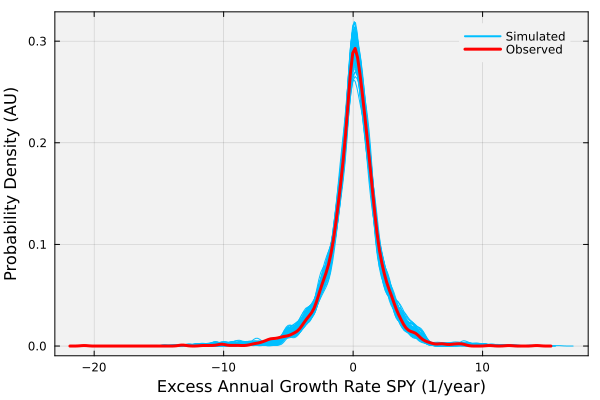

In [34]:
let
    q = plot(); 
    density!(in_sample_decoded_archive_with_jumps[:,1], lw=2, c=:deepskyblue1, label="Simulated", 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    for i ∈ 2:number_of_paths
        density!(in_sample_decoded_archive_with_jumps[:,i], lw=1, c=:deepskyblue1, label="")
    end
    density!(in_sample_dataset, c=:red, lw=3, label="Observed")
    xlabel!("Excess Annual Growth Rate $(myticker) (1/year)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
    current()
end

### Check: Are the predicted jump model returns and observed in-sample distributions the same? 
If our jump Markov model is correct, then the observed excess growth rate distribution and the excess growth distribution calculated by our jump model should look like they are drawn from the same distribution. To check this hypothesis, use [the ApproximateTwoSampleKSTest exported by the HypothesisTests.jl package](https://github.com/JuliaStats/HypothesisTests.jl) with the hypotheses:

> __Test:__ The `H0:null hypothesis` is that `x` and `y` are drawn from the same distribution against the `H1:alternative hypothesis` that `x` and `y` come from different distributions.

Let's run [the ApproximateTwoSampleKSTest function](https://github.com/JuliaStats/HypothesisTests.jl) on a single (randomly selected) example trajectory to see what happens (most of the time, we fail to reject `H0`, i.e., the test suggests `x` and `y` are from the same distribution): 

In [35]:
let
    pvalue_cutoff = 0.05; # 95% cutoff
    pass_counter = 0;
    for i ∈ 1:number_of_paths
        test_value = ApproximateTwoSampleKSTest(in_sample_dataset,in_sample_decoded_archive_with_jumps[:,i]) |> pvalue
        if (test_value > pvalue_cutoff)
            pass_counter += 1 # we pass (fail to reject) x and y are from the same distribution
        end
    end
    println("Pass percentage: $((pass_counter/number_of_paths)*100)%")
end

Pass percentage: 98.0%


### Visualize an example in-sample jump return trajectory
`Unhide` the code block to see how we plotted the observed (red) and simulated (blue) excess growth rate values for a randomly selected sample model generated sample path.

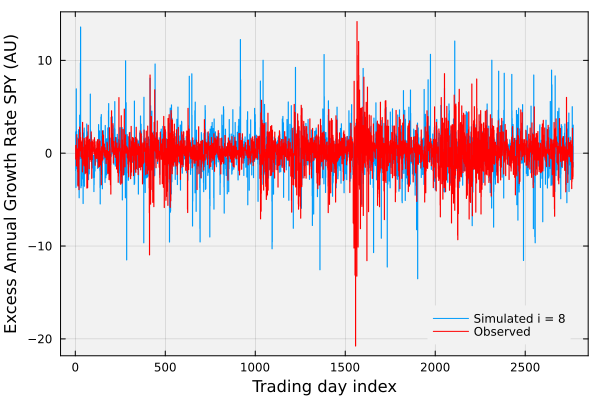

In [36]:
let
    number_of_steps = maximum_number_trading_days;
    index_to_plot = rand(1:number_of_paths);
    index_to_plot = 8;
    plot(in_sample_decoded_archive_with_jumps[:,index_to_plot], linetype=:steppost, label="Simulated i = $(index_to_plot)", 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    plot!(in_sample_dataset[1:(number_of_steps-1)], linetype=:steppost, c=:red, label="Observed")
    xlabel!("Trading day index", fontsize=18)
    ylabel!("Excess Annual Growth Rate $(myticker) (AU)", fontsize=18)
end

### Volatility clustering of the simulated dataset
Next, let's consider volatility clustering. Volatility clustering is determined by examining the autocorrelation of the absolute values of the excess growth rate for different lag values. In actual data, we expect a positive absolute autocorrelation for short lags. Volatility clustering indicates that periods of high volatility, such as significant changes in returns, tend to occur close together in time.

`Unhide` the code block below to see how we computed and plotted the [autocorrelation function](https://en.wikipedia.org/wiki/Autocorrelation) for the absolute values of the simulated and observed out-of-sample excess growth rates.
* The observed out-of-sample dataset (red line) shows a positive autocorrelation for lags less than approximately `30 days` at a 99% confidence level. This suggests the market has a memory of approximately 30 days or less following large disruptions.
* The excess growth rate trajectories produced by the Jump Markov model (blue line) also show volatility clustering if we select a trajectory with jumps; thus, this model captures the clustering of high-volatility events.

So what do we see?

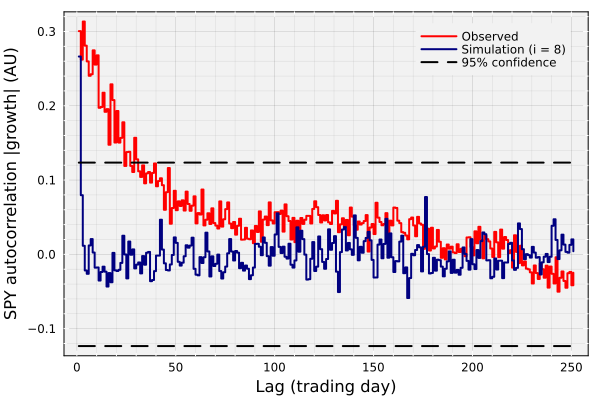

In [37]:
let

    # initialize -
    gain_color = colorant"#06d6a0";
    loss_color = colorant"#ef476f";
    
    # generate a random index -
    random_index = rand(1:number_of_paths);
    random_index = 8; # TODO: set this to a value that has jumps -
    number_of_steps = 252;
    
    L = number_of_steps;
    τ  = range(1,step=1,stop=(L-1));
    AC_observed = autocor(abs.(Rᵢ), τ); 
    AC_simulation = autocor(abs.(in_sample_decoded_archive_with_jumps[:,random_index]), τ);
    
    # plot(AC_observed, label="Observed", lw=1, c=:red, 
    #     bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, linetype=:steppost)

    plot(AC_observed,  label="Observed", linetype=:steppost, foreground_color_axis=:white, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, 
        c=:red, lw=2, xminorticks=true, yminorticks=true, minorgrid=true)
    
    plot!(AC_simulation, c=:navy, lw=2,label="Simulation (i = $(random_index))", linetype=:steppost)
    LINE = (1.96/sqrt(number_of_steps))*ones(number_of_steps-1);
    plot!(LINE, label="95% confidence", lw=2, c=:black, ls=:dash)
    plot!(-LINE, label="", lw=2, c=:black, ls=:dash)
    xlabel!("Lag (trading day)", fontsize=18)
    ylabel!("$(myticker) autocorrelation |growth| (AU)", fontsize=18)

    # dump
    # savefig(joinpath(_PATH_TO_FIGURES, "Fig-$(myticker)-ExcessGrowthRate-VolClustering-Daily-HMM-BB.svg"))
end

#### Save the HMM model and other data to a file
Later, we'll use the hidden Markov Model (HMM) we developed here. Let's save the model to disk to save some time later on. Use the [save(...) method exported by the JLD2.jl package](https://github.com/JuliaIO/JLD2.jl.git) to write a [model file in HDF5 binary format](https://en.wikipedia.org/wiki/Hierarchical_Data_Format). First, we specify a `path` in the `path_to_save_file` variable:

In [38]:
path_to_save_file = joinpath(_PATH_TO_DATA,"HMM-WJ-$(myticker)-N-$(number_of_states)-daily-aggregate.jld2");

Then we write an [`HDF5 binary file`](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) holding our data to the location specified by `path_to_save_file`. We use the [save(...) function exported by the JLD2.jl package to write a binary save file](https://github.com/JuliaIO/JLD2.jl.git) (later we'll use the `load(...)` function to reload this data):

In [39]:
save(path_to_save_file, Dict("model"=>model, "jump_model" => jump_model, 
        "risk_free_rate" => risk_free_rate,
        "number_of_states" => number_of_states,
        "decode"=>decode_distribution_model, "stationary"=>π̄, 
        "insampledataset"=>in_sample_dataset, "encoded_archive" => encoded_archive, "encoded_archive_with_jumps" => encoded_archive_with_jumps,
        "in_sample_decoded_archive_with_jumps" => in_sample_decoded_archive_with_jumps, 
        "in_sample_decoded_archive" => in_sample_decoded_archive));

In [40]:
length(Rᵢ)

2766

In [41]:
length(list_of_tickers)

424

___

## Summary
This example demonstrates how to construct and validate a hidden Markov model for daily stock excess growth rates using SPY ETF data.

> __Key Takeaways:__
>
> * __Hidden Markov models partition return space into discrete states using quantile-based boundaries:__ The cumulative distribution function of observed excess returns determines category thresholds, and transition probabilities are estimated by counting state-to-state transitions in historical sequences. The emission matrix equals the identity matrix when states are fully observable.
> * __Simulated trajectories from HMMs reproduce distributional properties of observed returns:__ Monte Carlo sampling from stationary distributions and estimated transition matrices generates synthetic return sequences that pass statistical tests comparing them to observed data. Decoding states into returns uses fitted Normal distributions for each state category.
> * __Jump-augmented HMMs capture volatility clustering in financial time series:__ Adding jump events to tail states with Poisson-distributed durations improves model fit to observed autocorrelation patterns in absolute returns. The jump model maintains statistical similarity to observed distributions while generating trajectories with clustered high-volatility events.

Hidden Markov models provide a framework for modeling regime-switching behavior in financial time series.
___

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses should be used.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.